In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

['ID', 'inputs', 'outputs', 'T/K', 'sigma/kbT', 'nDonors']
max==0.26793539247232034, min==-0.2548849766048757
temp==[77.]
sigma==[0.]
nDonors==[3]
[[ 0.          1.13895128  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.23895838  0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.1658078   0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.93558321  0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -1.11650254  0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -1.17143521  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          1.22358152  0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0.1412415   0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.11252575  0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -0

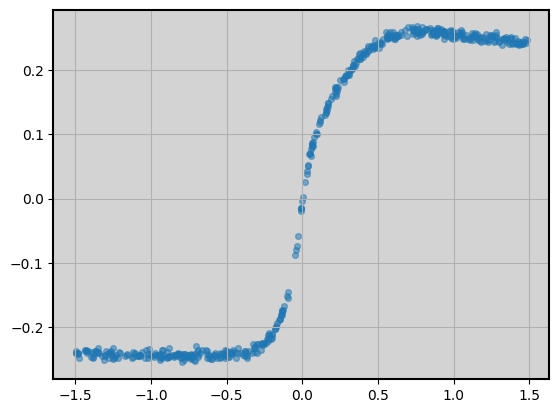

In [4]:
batch = np.load("currentData/batch_sig=0.0.npz")
print(batch.files)
inputs = batch["inputs"]
outputs = batch["outputs"]

max_output = outputs.max()
min_output = outputs.min()

print(f"max=={max_output}, min=={min_output}")
print(f"temp=={batch['T/K']}\n"
      f"sigma=={batch['sigma/kbT']}\n"
      f"nDonors=={batch['nDonors']}")

print(inputs[:10, :])

plt.scatter(
    inputs[:, 1], 
    outputs,
    alpha=0.5,
    s=17)

ax = plt.gca()
ax.grid(True)
ax.spines[["top", "bottom", "left", "right"]].set_linewidth(1.5)
ax.set_facecolor("lightgrey")

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,
                 inputs: np.array,
                 outputs: np.array) -> None:
        
        self.transform = None

In [ ]:
class NeuralNet(torch.nn.module):
    def __init__(self,
                 paramDict: dict) -> None:
        super().__init__()
        """
        Network pars
        """
        self.latent_dim = paramDict['latent_dim']
        self.input_dim = paramDict['input_dim']
        self.output_dim = paramDict['output_dim']
        
        self.num_layers = paramDict['num_layers']
        
        self.epochs = paramDict['epochs']
        self.lr = paramDict['lr']

        self.training_loss = []
        self.test_loss = []

        self.network = self._build_model()

        self.loss_fn = torch.nn.MSELoss()


    def _build_model(self) -> nn.Sequential:
        
        network_layers = []
        network_layers += [nn.Linear(self.input_dim, self.latent_dim, bias=True)]
        network_layers += [nn.ReLU]

        for _layer in range(self.num_layers):
            network_layers+=[nn.Linear(self.latent_dim, self.latent_dim, bias=True)]
            network_layers+=[nn.ReLU]
        
        network_layers += [nn.Linear(self.latent_dim, self.output_dim, bias=True)]
        network_layers += [nn.Sigmoid()]

        network_block = nn.Sequential(*network_layers)

        return network_block
        
    def forward(self, x) -> torch.Tensor:

        x = self.network(x)

        return x
    
    def calculate_loss(self, y, y_hat):

        loss = self.loss_fn(y, y_hat)

        return loss
        
    
def train(neural_net: torch.nn.Module,
          optimizer: torch.optim,
          learning_rate: float,
          epochs: int,
          dataloader: DataLoader
          ):
    
    losses = []

    for _epoch in range(epochs):
        for batch in dataloader:
            optimizer.zero_grad()
            x, y = batch

            y_hat = neural_net(x)

            loss = neural_net.calculate_loss(y, y_hat)

            loss.backward()

            optimizer.step()

    return losses
    


SyntaxError: incomplete input (2501078605.py, line 51)

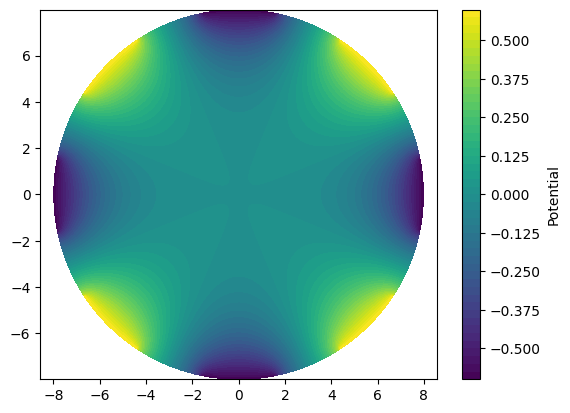

In [ ]:
df = pd.read_csv("potential.csv")
plt.tricontourf(df.x, df.y, df.potential, levels=50)
plt.colorbar(label="Potential")
plt.axis("equal")
plt.show()


(100,)


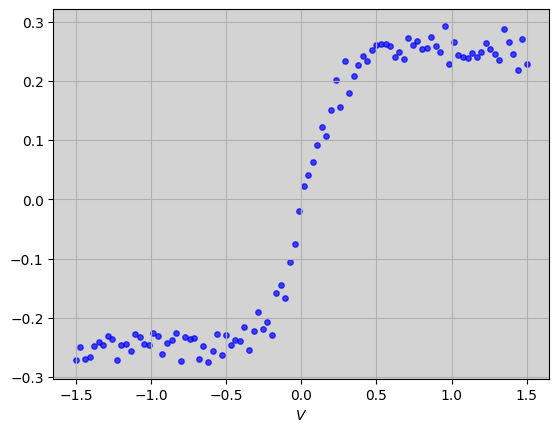

In [ ]:
data = np.genfromtxt("iv_curve.csv", delimiter=",")
print(data.shape)

vs = np.linspace(-1.5, 1.5, len(data))

fig, ax = plt.subplots()

ax.set_facecolor("lightgrey")
ax.grid(True)
ax.set_xlabel("$V$")
ax.scatter(vs, data, s=15, alpha=.7, color="blue")

['input_idx', 'output_idx', 'control_voltages', 'inputs', 'outputs']


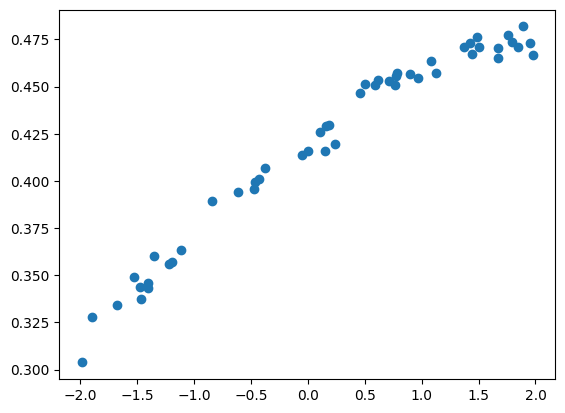

In [7]:
sweep_data = np.load("currentData/sweep_test.npz")
print(sweep_data.files)

in_idx = sweep_data["input_idx"]
out_idx = sweep_data["output_idx"]
control_voltages = sweep_data["control_voltages"]
inputs = sweep_data["inputs"]
outputs = sweep_data["outputs"]

plt.scatter(inputs, outputs)